In [1]:
import os
import ast
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ray.tune.registry import register_env
from ray.rllib.algorithms.algorithm import Algorithm
from jaxmarl.environments.coin_game.coin_game_rllib_env import CoinGameRLLibEnv

## Obtaining policy

In [2]:
def env_creator(env_config):
    return CoinGameRLLibEnv(**env_config)

register_env("coin_game_env_RLLIB", env_creator)

In [12]:
# Ruta base donde buscar los entrenamientos
DILEMMA = 0

if DILEMMA == 0:
    BASE_PATH = f"/home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma"
elif DILEMMA == 1:
    BASE_PATH = f"/home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/Prisioner_dilemma"


# REWARD_COEFs a buscar
REWARD_COEFS = [
    [[0.707107, 0.707107], [1.0, 0.0]],
    [[0.707107, -0.707107], [1.0, 0.0]]
]

agent_id = 1

CHECKPOINT = 4500

In [13]:
MOVES = np.array([
    [0, 1],   # right
    [0, -1],  # left
    [1, 0],   # up
    [-1, 0],  # down
    [0, 0],   # stay
])

In [14]:
# Función para leer el REWARD_COEF de un config.txt
def get_reward_coef(config_path):
    with open(config_path, 'r') as f:
        for line in f:
            if line.strip().startswith('REWARD_COEF'):
                # Extrae la parte después del igual
                coef_str = line.split(':', 1)[1].strip()
                try:
                    coef = ast.literal_eval(coef_str)
                    return coef
                except Exception as e:
                    print(f"Error parsing REWARD_COEF in {config_path}: {e}")
    return None

# Busca los directorios que contienen los REWARD_COEF deseados
def find_training_dirs():
    matches = {}
    for dir_name in os.listdir(BASE_PATH):
        dir_path = os.path.join(BASE_PATH, dir_name)
        if not os.path.isdir(dir_path):
            continue
        config_path = os.path.join(dir_path, 'config.txt')
        if not os.path.exists(config_path):
            continue
        coef = get_reward_coef(config_path)
        for target in REWARD_COEFS:
            if coef == target:
                matches[str(target)] = dir_path
    return matches

# Carga la política del segundo agente desde un checkpoint RLlib
def load_policy(checkpoint_dir, agent_id):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{CHECKPOINT}')
    # RLlib guarda un archivo extra con el nombre completo
    if not os.path.exists(checkpoint_path):
        # Busca el archivo real
        for f in os.listdir(checkpoint_dir):
            if f.startswith(f'checkpoint_{CHECKPOINT}'):
                checkpoint_path = os.path.join(checkpoint_dir, f)
                break
    # Carga el modelo con la API moderna
    algo = Algorithm.from_checkpoint(checkpoint_path)
    policy = algo.get_policy(f"agent_{agent_id}")
    return policy

In [15]:
def state_to_obs(state, grid_size=3):
    """
    state: dict with keys 'red_pos', 'blue_pos', 'red_coin_pos', 'blue_coin_pos'
           each value is a tuple (x, y)
    Returns: {'agent_0': obs0, 'agent_1': obs1}
    """
    obs1 = np.zeros((grid_size, grid_size, 4), dtype=np.int8)
    obs2 = np.zeros((grid_size, grid_size, 4), dtype=np.int8)
    # Fill channels for agent_0
    obs1[state['red_pos'][0], state['red_pos'][1], 0] = 1
    obs1[state['blue_pos'][0], state['blue_pos'][1], 1] = 1
    obs1[state['red_coin_pos'][0], state['red_coin_pos'][1], 2] = 1
    obs1[state['blue_coin_pos'][0], state['blue_coin_pos'][1], 3] = 1
    # For agent_1, swap red/blue and red_coin/blue_coin channels
    obs2[:, :, 0] = obs1[:, :, 1]  # blue
    obs2[:, :, 1] = obs1[:, :, 0]  # red
    obs2[:, :, 2] = obs1[:, :, 3]  # blue_coin
    obs2[:, :, 3] = obs1[:, :, 2]  # red_coin
    return {
        'agent_0': obs1.flatten(),
        'agent_1': obs2.flatten()
    }

def generate_all_valid_states(grid_size=3):
    positions = [(i, j) for i in range(grid_size) for j in range(grid_size)]
    states = []
    for red_pos in positions:
        for blue_pos in positions:
            if blue_pos == red_pos:
                continue
            for red_coin_pos in positions:
                if red_coin_pos == red_pos or red_coin_pos == blue_pos:
                    continue
                for blue_coin_pos in positions:
                    if blue_coin_pos in [red_pos, blue_pos, red_coin_pos]:
                        continue
                    state = {
                        'red_pos': red_pos,
                        'blue_pos': blue_pos,
                        'red_coin_pos': red_coin_pos,
                        'blue_coin_pos': blue_coin_pos
                    }
                    states.append(state)
    return states

def simple_adjacent(pos1, pos2, grid_size):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1]) == 1

def toroidal_adjacent(pos1, pos2, grid_size):
    dx = min(abs(pos1[0] - pos2[0]), grid_size - abs(pos1[0] - pos2[0]))
    dy = min(abs(pos1[1] - pos2[1]), grid_size - abs(pos1[1] - pos2[1]))
    return (dx == 1 and dy == 0) or (dx == 0 and dy == 1)

def classify_action(obs, action, grid_size=3):
    obs = np.array(obs).reshape((grid_size, grid_size, 4))
    # Channel 0: agent, 1: other agent, 2: own coin, 3: other coin
    agent_pos = np.argwhere(obs[:, :, 0] == 1)[0]
    own_coin_pos = np.argwhere(obs[:, :, 2] == 1)[0]
    other_coin_pos = np.argwhere(obs[:, :, 3] == 1)[0]
    move = MOVES[action]
    new_pos = (agent_pos + move) % grid_size
    result = [0, 0, 0, 0, 0]
    if np.array_equal(new_pos, own_coin_pos):
        result[0] = 1
    elif np.array_equal(new_pos, other_coin_pos):
        result[1] = 1
    else:
        own_adjacent = toroidal_adjacent(agent_pos, own_coin_pos, grid_size)
        other_adjacent = toroidal_adjacent(agent_pos, other_coin_pos, grid_size)
        if own_adjacent:
            result[2] = 1
        elif other_adjacent:
            result[3] = 1
        else:
            result[4] = 1
    return result

def extract_policy_to_csv(policy, output_csv, agent_id=0, grid_size=3):
    states = generate_all_valid_states(grid_size)
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(
            [f'obs_{i}' for i in range(grid_size*grid_size*4)] +
            ['action',
             'own_coin_collected', 'other_coin_collected',
             'reject_own_coin', 'reject_other_coin', 'no_coin_visible']
        )
        for state in states:
            obs_dict = state_to_obs(state)  # returns dict for both agents
            obs = obs_dict[f'agent_{agent_id}']
            action = policy.compute_single_action(obs)
            if isinstance(action, tuple):
                action_val = action[0]
            else:
                action_val = action
            metrics = classify_action(np.array(obs), action_val, grid_size=grid_size)
            writer.writerow(list(obs) + [action_val] + metrics)

In [16]:
matches = find_training_dirs()
for coef, dir_path in matches.items():
    checkpoint_dir = os.path.join(dir_path, f'checkpoint_{CHECKPOINT}')
    print(f"Cargando política del segundo agente para REWARD_COEF={coef} en {checkpoint_dir}")
    try:
        for agent_id in [0,1]:
            policy = load_policy(dir_path, agent_id)
            output_csv = f"policy_agent_{agent_id}_checkpoint_{CHECKPOINT}.csv"
            output_path = os.path.join(dir_path, output_csv)
            extract_policy_to_csv(policy, output_path, agent_id, grid_size=3)
            print(f"CSV guardado en {output_path}")
            
    except Exception as e:
        print(f"Error cargando la política: {e}")

Cargando política del segundo agente para REWARD_COEF=[[0.707107, 0.707107], [1.0, 0.0]] en /home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma/Training_2025-06-23_00-34-37/checkpoint_4500


/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/tune/logger/unified.p

CSV guardado en /home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma/Training_2025-06-23_00-34-37/policy_agent_0_checkpoint_4500.csv


/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/tune/logger/unified.p

CSV guardado en /home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma/Training_2025-06-23_00-34-37/policy_agent_1_checkpoint_4500.csv
Cargando política del segundo agente para REWARD_COEF=[[0.707107, -0.707107], [1.0, 0.0]] en /home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma/Training_2025-06-20_12-03-15/checkpoint_4500


/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/tune/logger/unified.p

CSV guardado en /home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma/Training_2025-06-20_12-03-15/policy_agent_0_checkpoint_4500.csv


/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/samuel_lozano/miniconda3/envs/JaxMARL_TFM/lib/python3.10/site-packages/ray/tune/logger/unified.p

CSV guardado en /home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma/Training_2025-06-20_12-03-15/policy_agent_1_checkpoint_4500.csv


In [17]:
print(matches)

{'[[0.707107, 0.707107], [1.0, 0.0]]': '/home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma/Training_2025-06-23_00-34-37', '[[0.707107, -0.707107], [1.0, 0.0]]': '/home/samuel_lozano/data/samuel_lozano/coin_game/RLLIB/No_dilemma/Training_2025-06-20_12-03-15'}


## Comparing policy

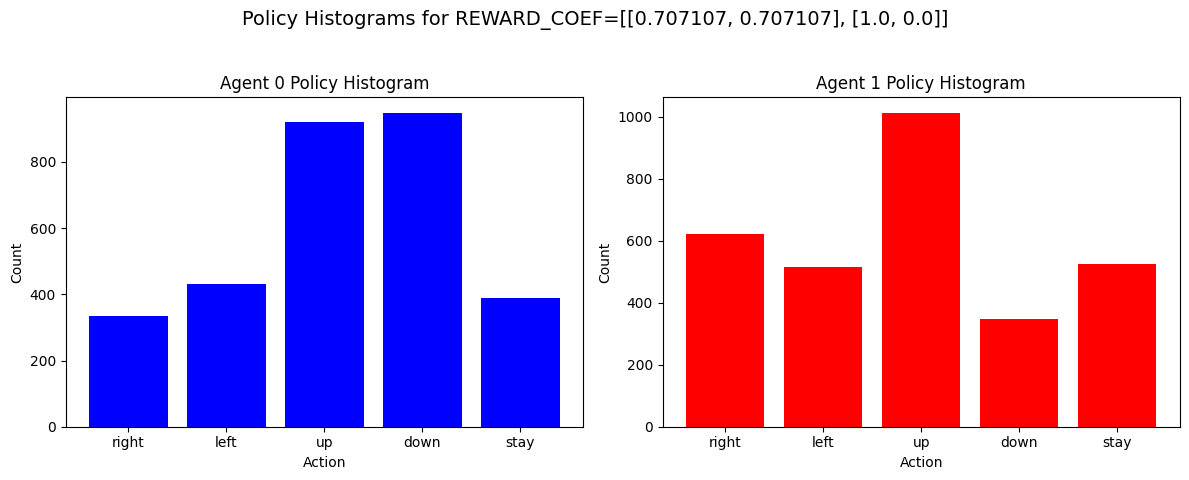

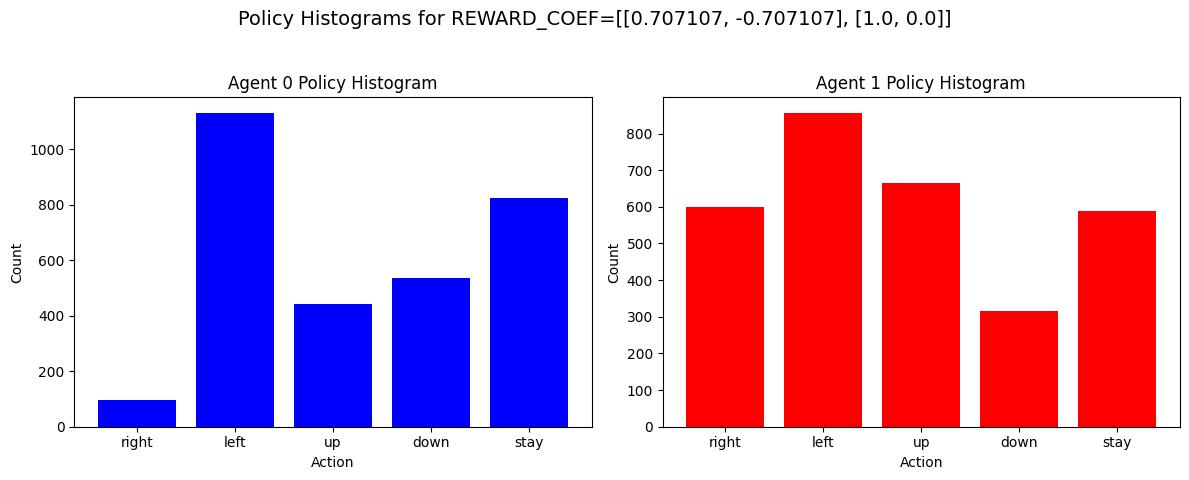

In [18]:
for coef, dir_path in matches.items():
    csv_agent_0 = os.path.join(dir_path, f'policy_agent_0_checkpoint_{CHECKPOINT}.csv')
    csv_agent_1 = os.path.join(dir_path, f'policy_agent_1_checkpoint_{CHECKPOINT}.csv')

    if not (os.path.exists(csv_agent_0) and os.path.exists(csv_agent_1)):
        print(f"CSV files not found for REWARD_COEF={coef} in {dir_path}")
        continue

    df0 = pd.read_csv(csv_agent_0)
    df1 = pd.read_csv(csv_agent_1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Policy Histograms for REWARD_COEF={coef}', fontsize=14)

    plt.subplot(1, 2, 1)
    plt.hist(df0['action'].dropna(), bins=range(6), align='left', rwidth=0.8, color='blue')
    plt.title('Agent 0 Policy Histogram')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks(range(5), ['right', 'left', 'up', 'down', 'stay'])

    plt.subplot(1, 2, 2)
    plt.hist(df1['action'].dropna(), bins=range(6), align='left', rwidth=0.8, color='red')
    plt.title('Agent 1 Policy Histogram')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks(range(5), ['right', 'left', 'up', 'down', 'stay'])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

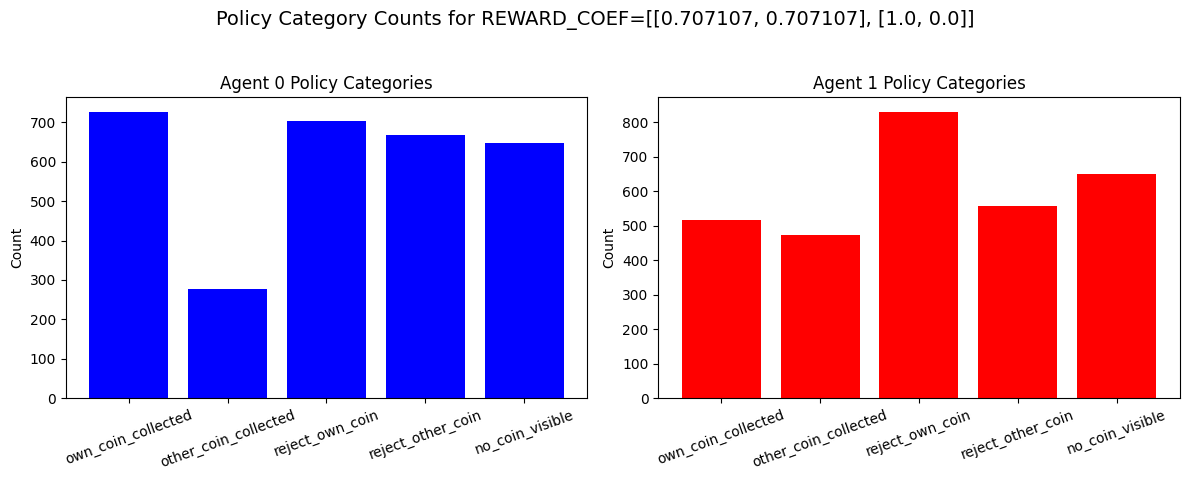

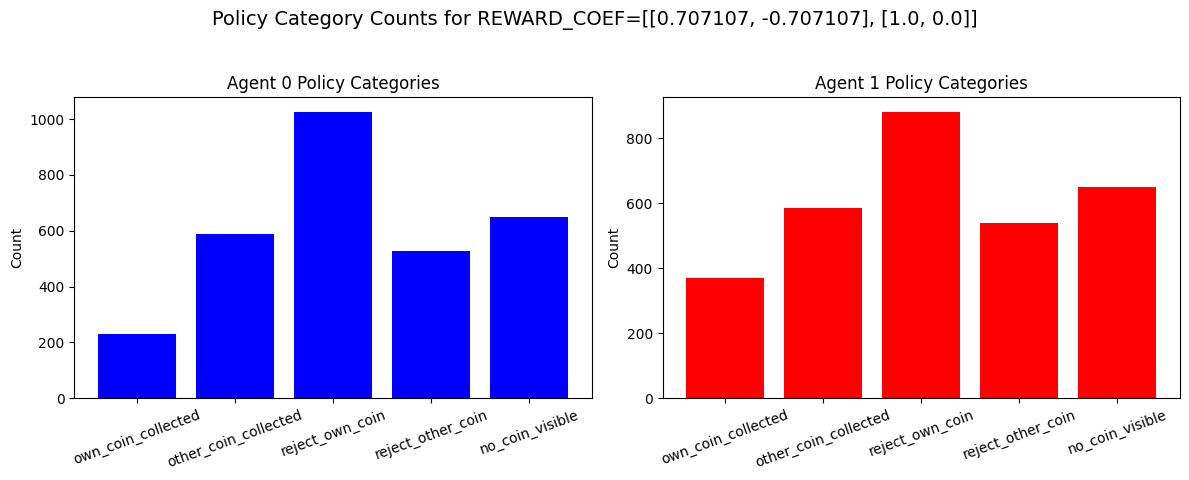

In [19]:
for coef, dir_path in matches.items():
    csv_agent_0 = os.path.join(dir_path, f'policy_agent_0_checkpoint_{CHECKPOINT}.csv')
    csv_agent_1 = os.path.join(dir_path, f'policy_agent_1_checkpoint_{CHECKPOINT}.csv')

    if not (os.path.exists(csv_agent_0) and os.path.exists(csv_agent_1)):
        print(f"CSV files not found for REWARD_COEF={coef} in {dir_path}")
        continue

    df0 = pd.read_csv(csv_agent_0)
    df1 = pd.read_csv(csv_agent_1)

    # The five category columns
    categories = [
        'own_coin_collected',
        'other_coin_collected',
        'reject_own_coin',
        'reject_other_coin',
        'no_coin_visible'
    ]

    # Count occurrences for each category
    counts0 = [df0[cat].sum() for cat in categories]
    counts1 = [df1[cat].sum() for cat in categories]

    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Policy Category Counts for REWARD_COEF={coef}', fontsize=14)

    plt.subplot(1, 2, 1)
    plt.bar(categories, counts0, color='blue')
    plt.title('Agent 0 Policy Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=20)

    plt.subplot(1, 2, 2)
    plt.bar(categories, counts1, color='red')
    plt.title('Agent 1 Policy Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=20)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

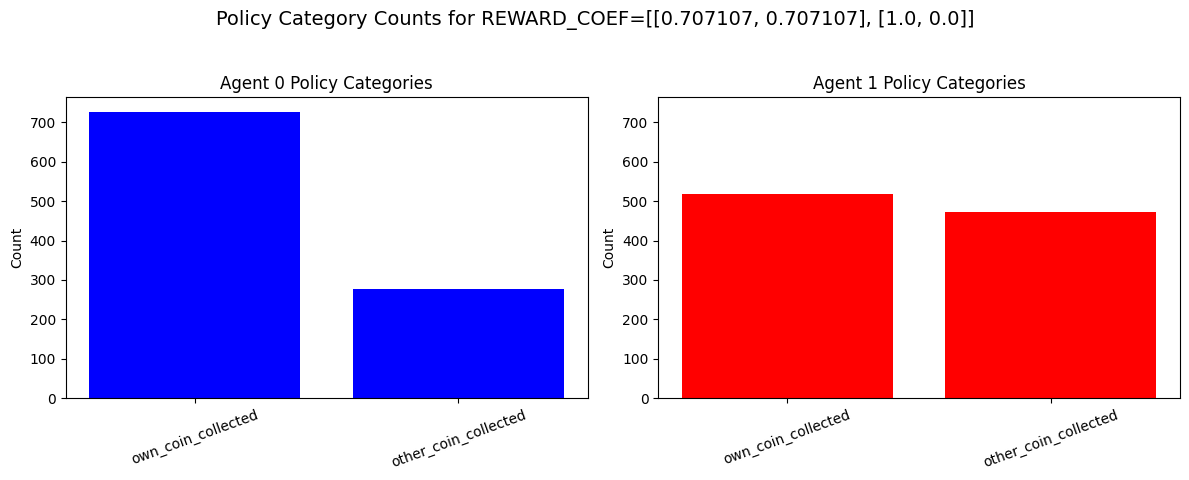

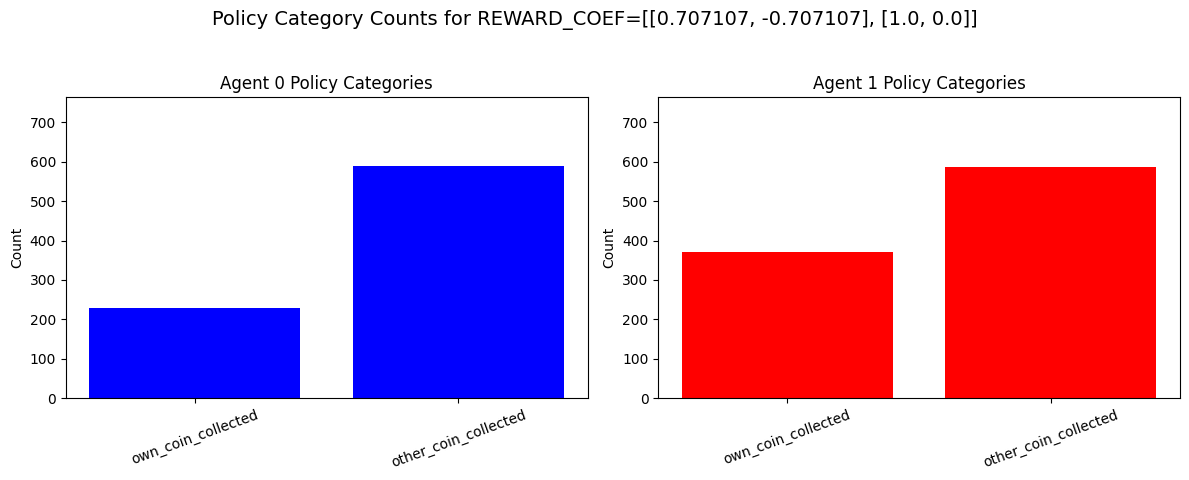

In [20]:
# First pass: find the global maximum count
global_max = 0
categories = [
    'own_coin_collected',
    'other_coin_collected'
    # Add more categories if needed
]

for coef, dir_path in matches.items():
    csv_agent_0 = os.path.join(dir_path, f'policy_agent_0_checkpoint_{CHECKPOINT}.csv')
    csv_agent_1 = os.path.join(dir_path, f'policy_agent_1_checkpoint_{CHECKPOINT}.csv')

    if not (os.path.exists(csv_agent_0) and os.path.exists(csv_agent_1)):
        continue

    df0 = pd.read_csv(csv_agent_0)
    df1 = pd.read_csv(csv_agent_1)
    counts0 = [df0[cat].sum() for cat in categories]
    counts1 = [df1[cat].sum() for cat in categories]
    local_max = max(counts0 + counts1)
    if local_max > global_max:
        global_max = local_max

# Second pass: plot with the same ylim
for coef, dir_path in matches.items():
    csv_agent_0 = os.path.join(dir_path, f'policy_agent_0_checkpoint_{CHECKPOINT}.csv')
    csv_agent_1 = os.path.join(dir_path, f'policy_agent_1_checkpoint_{CHECKPOINT}.csv')

    if not (os.path.exists(csv_agent_0) and os.path.exists(csv_agent_1)):
        print(f"CSV files not found for REWARD_COEF={coef} in {dir_path}")
        continue

    df0 = pd.read_csv(csv_agent_0)
    df1 = pd.read_csv(csv_agent_1)
    counts0 = [df0[cat].sum() for cat in categories]
    counts1 = [df1[cat].sum() for cat in categories]

    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Policy Category Counts for REWARD_COEF={coef}', fontsize=14)

    plt.subplot(1, 2, 1)
    plt.bar(categories, counts0, color='blue')
    plt.title('Agent 0 Policy Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=20)
    plt.ylim(0, global_max * 1.05)

    plt.subplot(1, 2, 2)
    plt.bar(categories, counts1, color='red')
    plt.title('Agent 1 Policy Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=20)
    plt.ylim(0, global_max * 1.05)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()